In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.losses import binary_crossentropy
import os


Dataset_used = "https://www.kaggle.com/datasets/vbookshelf/computed-tomography-ct-images/data"

# **Defining Functions**


##Data Generator function

In [ ]:
def data_generator(patient_folders_path, labels, batch_size , epochs=1):
    patient_ids = labels['PatientNumber'].unique()
    num_patients = len(patient_ids)

    for i in range(0,epochs):
      for offset in range(0, num_patients, batch_size):
        batch_patients = patient_ids[offset:offset + batch_size]

        X_batch = []
        y_batch = []

        for patient_no in batch_patients:
          path = os.path.join(patient_folders_path , f"{patient_no:03}")
          slice_imgs = []
          slice_labels = []
          if os.path.exists(path):
            bone_path = os.path.join(path , "bone")
            for f in sorted(os.listdir(bone_path)):
              img_path = os.path.join(bone_path , str(f))
              img = cv2.imread(img_path)
              # print(img.shape)
              slice_imgs.append(img)
              slice_no = str(f)
              sliceNo = int(slice_no.replace(".jpg" , ""))
              # print(patient_no)
              # print(sliceNo)
              label = labels[labels["PatientNumber"] == patient_no]
              slice_label = label[label["SliceNumber"] == sliceNo]
              slice_label_t = slice_label[["Fracture_Yes_No"]].values[0]

              slice_labels.extend(slice_label_t)

          slice_labels = np.array(slice_labels)
          slice_imgs = np.array(slice_imgs)
          # print(slice_labels.shape)
          # print(slice_imgs.shape)
          X_batch = (slice_imgs)
          y_batch = (slice_labels)


        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        # print(X_batch.shape)
        # print(y_batch.shape)
        yield X_batch , y_batch

        # print(X_batch.shape)
        # print(y_batch)
        # print(y_batch.shape)

## Model Building Function

In [ ]:
def build_model():
  resnet_model = Sequential()

  pretrained_model= tf.keras.applications.ResNet101(include_top=False,
                    input_shape=(650 , 650 , 3),
                    pooling='avg',classes=1,
                    weights='imagenet')
  for layer in pretrained_model.layers:
          layer.trainable=False

  resnet_model.add(pretrained_model)
  resnet_model.add(Flatten())
  resnet_model.add(Dense(650, activation='relu'))
  resnet_model.add(Dense(1, activation='sigmoid'))

  return resnet_model

# **Model training and evaluation**

In [ ]:
# Load labels
labels_file_path = '/content/drive/MyDrive/siddhi2.0/hemorrhage_diagnosis.csv'
labels = pd.read_csv(labels_file_path)

# Data paths and constants
patient_folders_path = '/content/drive/MyDrive/siddhi2.0/Patients_CT'  # Folder containing subfolders for each patient
batch_size = 1  # Number of patients to process per batch
epochs = 5

# Split the labels into training and validation sets
patients_train, patients_val = train_test_split(labels['PatientNumber'].unique(), test_size=0.2, random_state=42)
# print(patients_train)
# print(patients_val)
labels_train = labels[labels['PatientNumber'].isin(patients_train)]
labels_val = labels[labels['PatientNumber'].isin(patients_val)]
steps_per_epoch = len(patients_train) // batch_size

# print(labels_train)
# print(labels_val)

# Build the model
resnet_model = build_model()

# Train the model using the data generator
train_generator = data_generator(patient_folders_path, labels_train, batch_size , epochs)
val_generator = data_generator(patient_folders_path, labels_val, batch_size )

resnet_model.compile(optimizer=Adam(learning_rate=0.01),loss=binary_crossentropy,metrics=['accuracy'])


history = resnet_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(patients_val) // batch_size
)





171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/5
65/65 [==============================] - 715s 11s/step - loss: 4.8467 - accuracy: 0.9018 - val_loss: 4.1096 - val_accuracy: 0.9047
Epoch 2/5
65/65 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.8852

65/65 [==============================] - 431s 7s/step - loss: 1.0275 - accuracy: 0.8852
Epoch 3/5
65/65 [==============================] - 434s 7s/step - loss: 0.8581 - accuracy: 0.9003
Epoch 4/5
65/65 [==============================] - 442s 7s/step - loss: 0.6438 - accuracy: 0.9043
Epoch 5/5
65/65 [==============================] - 440s 7s/step - loss: 0.3260 - accuracy: 0.9265


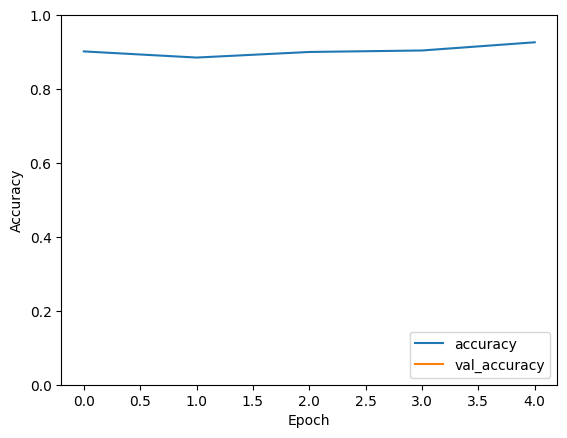

In [ ]:
resnet_model.save(r"/content/drive/MyDrive/siddhi2.0/Resnet-101-bone")
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()